In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.integrate as integrate
import seaborn as sns 
import colossus
sns.set_style("darkgrid")

# Colossus: Generating Halo Mass Function for Different Redshifts
In this code, we use Colossus to generate the halo mass function at different redshifts. When we calculate the total lensing cross-section, we need to know the number of available lenses in the universe at a particular instance. Therefore, we need to use Colossus to generate a comoving number density of haloes per its mass in redshift $z_{L}$ for a given mass range. 

website of Colossus: http://www.benediktdiemer.com/code/colossus/

In [3]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function

cosmology.setCosmology('planck13')
### Mass Range 
m = np.linspace(1E10,1E15, 10000)
mfunc_fof = mass_function.massFunction(m,z =0.0 , q_in= "M", q_out="dndlnM", mdef='vir', model = 'tinker08')

In [4]:
dlnm=(np.log(m)[-1] - np.log(m)[0])//len(m)

# Total Lensing Cross-section

The total lensing cross-section is given by the sum of available lenses at the universe at particular instant and its cross-section. Therefore, we need to (total number/ number density, etc) of available lenses at a certain redshift. In this code, we use the comoving number density of haloes per its logarithm of mass. In order to understand the total lensing cross-section for a source, we can imagine the physical picture as follow: 

Suppose we have a gravitational waves source from redshift $z_{S}$. When it is emitted from $z_{S}$, it will pass through the universe and approaching to us $z = 0$. However, during its propagation, it will pass through haloes in the universe, resulting in graviational lensing. Therefore, our job is to calculating the total lensing cross-section of gravitatinal waves source originates from $z_{S}$ which is the sum of the lensing cross-section of each hales at different lenses redshifts $z_{L} \in (0, z_{S})$.The equation of total lensing cross-section is given by the follow: 
\begin{equation}
\sigma^{S}_{total}(\mu,z_{S}) =  \frac{8 \pi^{3} G^{2}}{c^{4}}\frac{(\mu_{0}^{2}+1)}{(\mu_{0}^{2} -1)^{2}} \int^{z_{S}}_{0} \int_{\Omega_{M}} \frac{dn(M,z_{L})}{d \ln{M}} \Big( \frac{M}{r_{200}} \Big)^{2}\Big( \frac{d_{A}(z_{L},z_{S})}{d_{A}(z_{s})} \Big)^{2} d\ln{M} dV(z_{L})
\end{equation}
$\Omega_{M}$ is the integral domain of mass of available lenses in particular lens redshift $z_{L}$.  This lensing cross-section will tell us the relevant probability of a gravitational waves source in $z_{S}$ will be maginified by $\mu$.

In astropy Libary, we can call cosmo.differential_comoving_volume(z) to calculate the differential volume. However, the unit of differential comoving volume is in volume per solid angle per redshift. Therefore, when we need to calculate the integral of differential volume, we are in fact calculating this:
\begin{equation}
dV = 4 \pi \Big(\frac{dV}{d \Omega dz} \Big)_{astropy} dz
\end{equation}

Hence, the equation becomes:
\begin{equation}
\sigma^{S}_{total}(\mu,z_{S}) =  \frac{8 \pi^{3} G^{2}}{c^{4}}\frac{(\mu_{0}^{2}+1)}{(\mu_{0}^{2} -1)^{2}} \int^{z_{S}}_{0} \int_{\Omega_{M}} \frac{dn(M,z_{L})}{d \ln{M}} \Big( \frac{M}{r_{200}} \Big)^{2}\Big( \frac{d_{A}(z_{L},z_{S})}{d_{A}(z_{s})} \Big)^{2} d\ln{M}  \Big(4 \pi \Big(\frac{dV}{dz_{L}} \Big) \Big)dz_{L}
\end{equation}

In [5]:
# Using Astropy to calculate the total lensing cross section of source plane 
import astropy 
#from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
#cosmo = FlatLambdaCDM(H0=70*u.km/u.s/u.Mpc, Om0=0.3)
from colossus.halo import mass_so


## constants in computation
c = 3E8
G = 6.6748E-11
H_0 = cosmo.H(0)

#Assume Virial mass
def r_200(m,zl): 
    return (m*G/(100*Hubble(zl)**2))**(1/3)

### Colossus R_200c function 
def R_200c(m,zl):
    #return np.array([mass_so.M_to_R(m, i, '200c') for i in zs])
    return mass_so.M_to_R(m, zl, '200c')

# Comoving Number density of Haloes per ln(Haloes Mass)
def dndlnm(m,zl):
    return  mass_function.massFunction(m,z=zl , q_in= "M", q_out="dndlnM", mdef='200c', model = 'watson13')

# Maginification of Gravotational waves 
def mu_gw(zs):
    # zs > 0.3 by computation
    return (cosmo.luminosity_distance(zs)/cosmo.luminosity_distance(0.15))**2 

In [6]:
# Gws source range z_{S} = 0.01 ~ 5 since z_{L} < z_{S}
zs = np.linspace(0.001,100,20)

In [7]:
def integrand(m,zs):
    ### Constant
    const = 32*np.pi**4*G**2*c**-4
    f = lambda i:np.average(dndlnm(m,i)*(m/R_200c(m,i))**2)*cosmo.differential_comoving_volume(i).value*\
    cosmo.angular_diameter_distance_z1z2(i,zs).value**2
    result = integrate.quad(f,0,zs)
    return const*result[0]

In [8]:
cross_sec =  np.asarray([cosmo.angular_diameter_distance(i).value**-2*integrand(m,i) for i in zs])

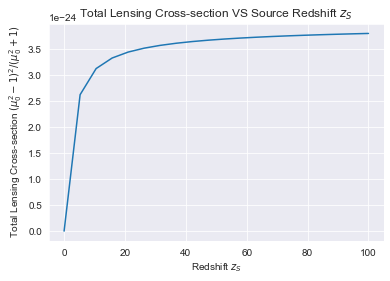

In [9]:
plt.plot(zs,cross_sec)
plt.title(r"Total Lensing Cross-section VS Source Redshift $z_{S} $ ")
plt.ylabel(r" Total Lensing Cross-section $(\mu_{0}^{2}-1)^{2}/(\mu_{0}^{2} +1)$")
plt.xlabel(r"Redshift $z_{S}$")
plt.savefig("cs_vs_zs_0_to_100.pdf")

In [11]:
### Range for small source redshift
z_mu = np.linspace(0.16,1.2,20)

In [12]:
cs_vs_mu = np.asarray([(mu_gw(i)**2+1)*(mu_gw(i)**2-1)**-2*cosmo.angular_diameter_distance(i).value**-2*integrand(m,i) for i in z_mu])

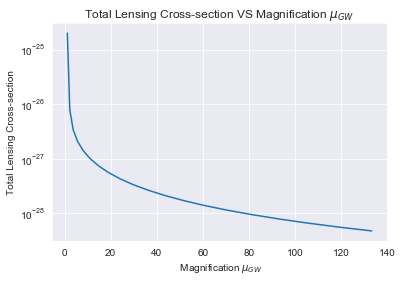

In [16]:
plt.plot(mu_gw(z_mu), cs_vs_mu)
plt.yscale("log")
plt.title(r"Total Lensing Cross-section VS Magnification $\mu_{GW}$")
plt.xlabel(r" Magnification $\mu_{GW}$")
plt.ylabel(r"Total Lensing Cross-section")
plt.savefig("cs_vs_mu.pdf")